In [1]:
# Load self-defined functions.
%run tools.ipynb

# Load libraries.
import pandas as pd
import numpy as np
import time
import pickle
from matminer.featurizers.site import CrystalNNFingerprint  
from matminer.featurizers.structure import SiteStatsFingerprint
from KmdPlus import StatsDescriptor, formula_to_composition 
from pymatgen.core.composition import Composition
import matplotlib.pyplot as plt
from collections import Counter
import math
import copy
from scipy.spatial import distance_matrix
import itertools

# Load materials project data.
MP_data = pd.read_pickle("data_set/paper_used_mp_data_20211107.pd.xz")
test_data = pd.read_pickle("data_set/all_searching_targets_20211107_with_predictions.pd.xz")

# Exclude all formula in test data from MP data.
MP_data_left = MP_data[np.invert(MP_data.pretty_formula.isin(test_data.pretty_formula))]
# Get stable data.
MP_stable = MP_data_left[MP_data_left.e_above_hull.values == 0]
# Delete overlapping formula in stable data.
count = Counter(MP_stable.pretty_formula).most_common()
keys = np.array([count[i][0] for i in range(len(count))])
freqs = np.array([count[i][1] for i in range(len(count))])
overlapping_formulas = keys[freqs>1]

excl_ids = []
for i in range(len(overlapping_formulas)):
    x = MP_stable[MP_stable.pretty_formula.values == overlapping_formulas[i]]
    x_sorted = x.sort_values("final_energy_per_atom")
    excl_ids.append(np.asarray(x_sorted.index[1:]))
    
MP_stable = MP_stable[np.invert(MP_stable.index.isin(np.concatenate(excl_ids)))]
MP_stable

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,...,efermi,final_energy_per_atom,formation_energy_per_atom,has_bandstructure,is_ordered,oxide_type,point_group,pretty_formula,total_magnetization,volume
id,,,,,,,,,,,,,,,,,,,,,
mp-1006278,Ac1Eu1Au2,"{'Ac': 1.0, 'Eu': 1.0, 'Au': 2.0}","(1.0, 1.0, 2.0)",4.0,"(Ac, Au, Eu)",3,225,Fm-3m,"{'Ac': {'b': 4}, 'Eu': {'a': 4}, 'Au': {'c': 8}}","{'Ac': ('b',), 'Eu': ('a',), 'Au': ('c',)}",...,4.883417,-6.019130,-0.776843,True,True,None,m-3m,AcEuAu2,1.627705,117.080578
mp-1017985,Ti2Ag2,"{'Ti': 2.0, 'Ag': 2.0}","(2.0, 2.0)",4.0,"(Ag, Ti)",2,129,P4/nmm,"{'Ti': {'c': 2}, 'Ag': {'c': 2}}","{'Ti': ('c',), 'Ag': ('c',)}",...,4.709549,-5.429487,-0.065696,True,True,None,4/mmm,TiAg,0.000432,70.460966
mp-1018128,Sc1Ag2,"{'Sc': 1.0, 'Ag': 2.0}","(1.0, 2.0)",3.0,"(Ag, Sc)",2,139,I4/mmm,"{'Sc': {'a': 2}, 'Ag': {'e': 4}}","{'Sc': ('a',), 'Ag': ('e',)}",...,3.934398,-4.301338,-0.302162,True,True,None,4/mmm,ScAg2,0.003584,57.497334
mp-1018131,Lu1Ag2,"{'Lu': 1.0, 'Ag': 2.0}","(1.0, 2.0)",3.0,"(Ag, Lu)",2,139,I4/mmm,"{'Lu': {'a': 2}, 'Ag': {'e': 4}}","{'Lu': ('a',), 'Ag': ('e',)}",...,3.456485,-3.736455,-0.341119,True,True,None,4/mmm,LuAg2,0.004292,62.417938
mp-1025059,La2Ag4,"{'La': 2.0, 'Ag': 4.0}","(2.0, 4.0)",6.0,"(Ag, La)",2,74,Imma,"{'La': {'e': 4}, 'Ag': {'h': 8}}","{'La': ('e',), 'Ag': ('h',)}",...,5.563882,-3.832468,-0.298780,True,True,None,mmm,LaAg2,0.000054,150.182757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-945077,Y2Te6,"{'Y': 2.0, 'Te': 6.0}","(2.0, 6.0)",8.0,"(Te, Y)",2,63,Cmcm,"{'Y': {'c': 4}, 'Te': {'c': 12}}","{'Y': ('c',), 'Te': ('c', 'c', 'c')}",...,5.933911,-4.907222,-0.933227,True,True,None,mmm,YTe3,0.000283,245.997038
mp-972256,Xe1,{'Xe': 1.0},"(1.0,)",1.0,"(Xe,)",1,166,R-3m,{'Xe': {'a': 1}},"{'Xe': ('a',)}",...,-6.965177,-0.036174,0.000000,True,True,None,-3m,Xe,0.000000,85.786507
mp-972364,Yb3,{'Yb': 3.0},"(3.0,)",3.0,"(Yb,)",1,166,R-3m,"{'Yb': {'a': 1, 'c': 2}}","{'Yb': ('a', 'c')}",...,1.419946,-1.539595,0.000000,True,True,None,-3m,Yb,0.000007,123.042457


In [2]:
# Delete unused data.
del MP_data
del MP_data_left

# Element-level descriptors of shape (94, 58).
element_features = pd.read_csv("data_set/element_features.csv", index_col= 0)

# Load the pre-calculated fingerprints (run Create_strcmp_fgp.ipynb for creating them).
strfgp = np.load("data_set/strfgp_stable_20211107.npy") # Structure fingerprints.
cmpfgp = np.load('data_set/cmpfgp_stable_20211107.npy') # Compositional fingerprints.

# Scaling cmpfgp.
cmpfgp_scaled = (cmpfgp - cmpfgp.mean(axis=0))/cmpfgp.std(axis=0, ddof=1)

# Convert chemical formulas to compositions.
MP_weight = np.array([formula_to_composition(MP_stable.pretty_formula[i]) for i in range(MP_stable.shape[0])])

# Get composition ratio and their labels.
ratio, ratio_label = [], []
for i in range(MP_stable.shape[0]):
    sorted_weight = np.sort(MP_weight[i])[::-1]
    comp = Composition(MP_stable.pretty_formula[i])
    comp_ratio = comp.num_atoms * sorted_weight
    x = [int(round(comp_ratio[j])) for j in range(MP_stable.n_elements[i])]
    gcd_x = math.gcd(*x) 
    # For collection in the case like "O2", "Na2O2".
    if gcd_x != 1:
        x = [int(round(x[k]/gcd_x)) for k in range(len(x))]
    else:
        pass
    # Get ratio label for collected x.
    label = ""
    for j in range(len(x)):
        label += f"{x[j]}:"
    # Save results.
    ratio_label.append(label[:-1])
    ratio.append(x)
    
## Add descriptors and ratio information to data.
MP_stable["materials_id"] = copy.deepcopy(MP_stable.index) # add ids as a new collumn.
MP_stable["cmpfgp"] = [cmpfgp_scaled[i] for i in range(cmpfgp_scaled.shape[0])] # scaled version.
MP_stable["strfgp"] = [strfgp[i] for i in range(strfgp.shape[0])]
MP_stable["comp_ratio"] = ratio
MP_stable["comp_ratio_label"] = ratio_label

Number of ratio labels: 2009
Number of unique formulas: 33064
Number of labels (N=1): 1047


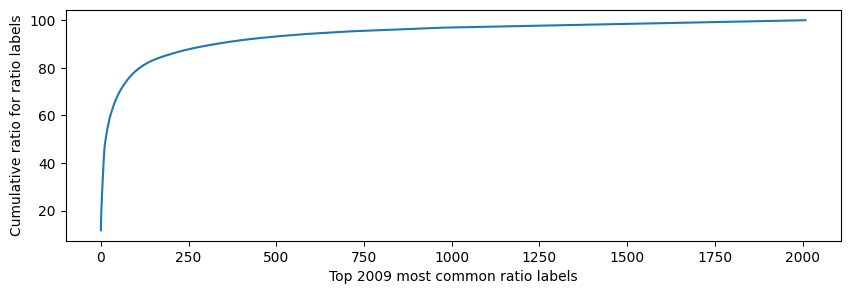

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,...,point_group,pretty_formula,total_magnetization,volume,materials_id,cmpfgp,strfgp,comp_ratio,comp_ratio_label,ratio_class
id,,,,,,,,,,,,,,,,,,,,,
mp-1006278,Ac1Eu1Au2,"{'Ac': 1.0, 'Eu': 1.0, 'Au': 2.0}","(1.0, 1.0, 2.0)",4.0,"(Ac, Au, Eu)",3,225,Fm-3m,"{'Ac': {'b': 4}, 'Eu': {'a': 4}, 'Au': {'c': 8}}","{'Ac': ('b',), 'Eu': ('a',), 'Au': ('c',)}",...,m-3m,AcEuAu2,1.627705,117.080578,mp-1006278,"[2.771876949006818, 1.1865512400030185, 1.3736...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 1, 1]",2:1:1,2:1:1
mp-1017985,Ti2Ag2,"{'Ti': 2.0, 'Ag': 2.0}","(2.0, 2.0)",4.0,"(Ag, Ti)",2,129,P4/nmm,"{'Ti': {'c': 2}, 'Ag': {'c': 2}}","{'Ti': ('c',), 'Ag': ('c',)}",...,4/mmm,TiAg,0.000432,70.460966,mp-1017985,"[0.1350964788236539, -0.3146123122899018, 0.72...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1]",1:1,1:1
mp-1018128,Sc1Ag2,"{'Sc': 1.0, 'Ag': 2.0}","(1.0, 2.0)",3.0,"(Ag, Sc)",2,139,I4/mmm,"{'Sc': {'a': 2}, 'Ag': {'e': 4}}","{'Sc': ('a',), 'Ag': ('e',)}",...,4/mmm,ScAg2,0.003584,57.497334,mp-1018128,"[0.3701583036849434, -0.036045879905648566, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 1]",2:1,2:1
mp-1018131,Lu1Ag2,"{'Lu': 1.0, 'Ag': 2.0}","(1.0, 2.0)",3.0,"(Ag, Lu)",2,139,I4/mmm,"{'Lu': {'a': 2}, 'Ag': {'e': 4}}","{'Lu': ('a',), 'Ag': ('e',)}",...,4/mmm,LuAg2,0.004292,62.417938,mp-1018131,"[1.3921662378644646, 0.23220327720511438, 0.68...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 1]",2:1,2:1
mp-1025059,La2Ag4,"{'La': 2.0, 'Ag': 4.0}","(2.0, 4.0)",6.0,"(Ag, La)",2,74,Imma,"{'La': {'e': 4}, 'Ag': {'h': 8}}","{'La': ('e',), 'Ag': ('h',)}",...,mmm,LaAg2,0.000054,150.182757,mp-1025059,"[1.1060040162941984, 0.47981788376889506, 0.88...","[0.0007990796742680084, 0.0005650346563832462,...","[2, 1]",2:1,2:1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-945077,Y2Te6,"{'Y': 2.0, 'Te': 6.0}","(2.0, 6.0)",8.0,"(Te, Y)",2,63,Cmcm,"{'Y': {'c': 4}, 'Te': {'c': 12}}","{'Y': ('c',), 'Te': ('c', 'c', 'c')}",...,mmm,YTe3,0.000283,245.997038,mp-945077,"[1.0089132625471442, 0.8615570688880563, 1.108...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 1]",3:1,3:1
mp-972256,Xe1,{'Xe': 1.0},"(1.0,)",1.0,"(Xe,)",1,166,R-3m,{'Xe': {'a': 1}},"{'Xe': ('a',)}",...,-3m,Xe,0.000000,85.786507,mp-972256,"[1.3308457618136933, -0.2091900591404454, 0.34...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[1],1,1
mp-972364,Yb3,{'Yb': 3.0},"(3.0,)",3.0,"(Yb,)",1,166,R-3m,"{'Yb': {'a': 1, 'c': 2}}","{'Yb': ('a', 'c')}",...,-3m,Yb,0.000007,123.042457,mp-972364,"[2.3119733786260332, 2.6877147922959383, 2.253...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[1],1,1


In [3]:
# Count comp_ratio.
count = Counter(MP_stable.comp_ratio_label).most_common()
labels = np.array([count[i][0] for i in range(len(count))], dtype = "object")
freqs = np.array([count[i][1] for i in range(len(count))])

print(f"Number of ratio labels: {len(count)}")
print(f"Number of unique formulas: {sum(freqs)}")
print(f"Number of labels (N=1): {sum(freqs==1)}")

cum_ratio = 100 * np.cumsum(freqs)/sum(freqs)

i = len(cum_ratio)
plt.figure(figsize=(10,3))
plt.plot(np.arange(i), cum_ratio[:i])
plt.xlabel(f"Top {i} most common ratio labels")
plt.ylabel("Cumulative ratio for ratio labels")
plt.show()

# Create ratio class (others vs ratio labels).
thd_others = 10
labels_others = labels[freqs < thd_others]
ratio_class =  copy.deepcopy(MP_stable.comp_ratio_label.values)
ratio_class[MP_stable.comp_ratio_label.isin(labels_others)] = "others"
MP_stable["ratio_class"] = ratio_class
MP_stable

In [4]:
# Search templates with identical ratio for a given ratio label.
def Search_identical_ratio_templates(ratio_label, templates):
    comp_ratio_label = templates.comp_ratio_label.values
    return np.where(comp_ratio_label == ratio_label)[0]

# Down sampling for training and validation data.
def Downsampling_pd(data_pd, thd_percentage = 1.0): # randomness included.
    
    thd = round(data_pd.shape[0] * thd_percentage / 100) # tresholds for the number of ratio labels.
    ratio_class = data_pd.comp_ratio_label.unique() # original ratio label.
    
    data_pd_down = []
    for i in range(len(ratio_class)):
        x = data_pd[data_pd.comp_ratio_label == ratio_class[i]].reset_index(drop = True) # For each class except others.
        
        if x.shape[0] > thd:
            ix = np.sort(np.random.choice(x.shape[0], thd, replace=False)) # random down-sampling.
            data_pd_down.append(x.iloc[ix])
            
        else:
            data_pd_down.append(x)
            
    data_pd_down = pd.concat(data_pd_down).reset_index(drop = True)
    
    return data_pd_down

# Create dataset.
def create_dataset(data_pd, tau = 0.3):
    # Get unique comp ratio label.
    comp_ratio_label = data_pd.comp_ratio_label.unique()
    # for saving.
    sim_pairids = []
    dissim_pairids = []
    sim_abscmpfgp = []
    dissim_abscmpfgp = []
    sim_label = []
    dissim_label = []
    # randomness included.
    for i in range(len(comp_ratio_label)):
        # Get data for ith unique ratio label.
        x = data_pd[data_pd.comp_ratio_label == comp_ratio_label[i]].reset_index(drop=True)
        # For non unique ratio.
        if x.shape[0]>1:
            # Get pair ids for x.
            ids = np.arange(x.shape[0])
            comb2 = list(itertools.combinations(ids, 2))
            # Structure fingerprint for x.
            x_strfgp = x.strfgp.values
            x_strfgp = np.array([x_strfgp[i] for i in range(len(x_strfgp))])
            # Composition fingerprint for x.
            x_cmpfgp = x.cmpfgp.values
            x_cmpfgp = np.array([x_cmpfgp[i] for i in range(len(x_cmpfgp))])
            # Get materials id for x.
            x_materials_id = x.materials_id.values
            # Get dissims for structure fingerprints.
            dissim = distance_matrix(x_strfgp, x_strfgp)
            dissim_tri = np.array([dissim[comb2[i][0], comb2[i][1]] for i in range(len(comb2))]) # get tri
            # Get sim and dissim pairs.
            sim_pairs = np.array(comb2)[dissim_tri < tau]
            # No similar pairs.
            if sim_pairs.shape[0] < 1:
                pass
            # more similar pairs than dissimlar pairs.
            elif (len(comb2) - len(sim_pairs)) < len(sim_pairs):
                dissim_pairs = np.array(comb2)[dissim_tri >= tau] # all dissimilar pairs.
                # save results.
                sim_pairids.append(x_materials_id[sim_pairs])
                dissim_pairids.append(x_materials_id[dissim_pairs])
                sim_abscmpfgp.append(np.abs(x_cmpfgp[sim_pairs[:,0],:] - x_cmpfgp[sim_pairs[:,1],:]))
                dissim_abscmpfgp.append(np.abs(x_cmpfgp[dissim_pairs[:,0],:] - x_cmpfgp[dissim_pairs[:,1],:]))

                sim_label.append(np.repeat(comp_ratio_label[i], len(sim_pairs)))
                dissim_label.append(np.repeat(comp_ratio_label[i], len(dissim_pairs)))

            else:
                dissim_pairs = np.array(comb2)[dissim_tri >= tau]
                # downsampling dissim pairs.
                ix = np.sort(np.random.choice(np.arange(len(dissim_pairs)), len(sim_pairs), replace=False)) # random downsampling.
                dissim_pairs = dissim_pairs[ix,:]
                # save results.
                sim_pairids.append(x_materials_id[sim_pairs])
                dissim_pairids.append(x_materials_id[dissim_pairs])
                sim_abscmpfgp.append(np.abs(x_cmpfgp[sim_pairs[:,0],:] - x_cmpfgp[sim_pairs[:,1],:]))
                dissim_abscmpfgp.append(np.abs(x_cmpfgp[dissim_pairs[:,0],:] - x_cmpfgp[dissim_pairs[:,1],:]))

                sim_label.append(np.repeat(comp_ratio_label[i], len(sim_pairs)))
                dissim_label.append(np.repeat(comp_ratio_label[i], len(dissim_pairs)))
        # unique composition ratio.
        else: 
            pass
    # Summarize results.
    sim_pairids = np.concatenate(sim_pairids)
    dissim_pairids = np.concatenate(dissim_pairids)
    sim_label = np.concatenate(sim_label, dtype = "object")
    dissim_label = np.concatenate(dissim_label, dtype = "object")
    sim_abscmpfgp = np.concatenate(sim_abscmpfgp)
    dissim_abscmpfgp = np.concatenate(dissim_abscmpfgp)
    # Concatenate sim and dissim.
    X = np.concatenate([sim_abscmpfgp, dissim_abscmpfgp], 0)
    X_pair_ids = np.concatenate([sim_pairids, dissim_pairids], 0)
    y = np.concatenate([np.ones(sim_pairids.shape[0]), np.zeros(dissim_pairids.shape[0])])
    y_class = np.concatenate([sim_label, dissim_label])
    
    return {"X":X, "pair_ids":X_pair_ids, "y":y, "y_class":y_class}

In [5]:
# Creating ML data with random division (for ensemble learning, 5 dataset is created).
n_split = 5
MLdata = []
raw_MLdata = []
raw_MLdata_down = []
ratio_class = MP_stable.ratio_class.unique()

np.random.seed(1122) # Set seed.

for j in range(n_split):
    print(j)
    print("")
    # Train-val-test split (per class split).
    train_pd, val_pd, test_pd = [], [], []

    for i in range(len(ratio_class)):

        x = MP_stable[MP_stable.ratio_class == ratio_class[i]].reset_index(drop=True)
        divided = divide_dataset(x.shape[0], 0.2, 0.2) # random divide per class.
        x_train, x_val, x_test = x.iloc[divided['train_ids']], x.iloc[divided['val_ids']], x.iloc[divided['test_ids']]

        train_pd.append(x_train)
        val_pd.append(x_val)
        test_pd.append(x_test)

    train_pd, val_pd, test_pd = pd.concat(train_pd).reset_index(drop = True), pd.concat(val_pd).reset_index(drop = True), pd.concat(test_pd).reset_index(drop = True)

    raw_MLdata.append({"train":train_pd, "val":val_pd, "test":test_pd})
    
    # Down-sampling for training, validation and test data.
    train_pd_down = Downsampling_pd(train_pd, 1.0)
    val_pd_down = Downsampling_pd(val_pd, 1.0)
    test_pd_down = Downsampling_pd(test_pd, 1.0)
    
    raw_MLdata_down.append({"train":train_pd_down, "val":val_pd_down, "test":test_pd_down})

    print("training")
    print(Counter(train_pd.ratio_class).most_common()[:20])
    print(train_pd.shape[0])
    print("down-sampled ↓")
    print(Counter(train_pd_down.ratio_class).most_common()[:20])
    print(train_pd_down.shape[0])
    print("")
    print("validation")
    print(Counter(val_pd.ratio_class).most_common()[:20])
    print(val_pd.shape[0])
    print("down-sampled↓")
    print(Counter(val_pd_down.ratio_class).most_common()[:20])
    print(val_pd_down.shape[0])
    print("")
    print("test")
    print(Counter(test_pd.ratio_class).most_common()[:20])
    print(test_pd.shape[0])
    print("down-sampled↓")
    print(Counter(test_pd_down.ratio_class).most_common()[:20])
    print(test_pd_down.shape[0])
    print("")
    
    # Create dataset for train, validation, and test set.
    train_set, val_set, test_set = create_dataset(train_pd_down, 0.3), create_dataset(val_pd_down, 0.3), create_dataset(test_pd_down, 0.3)

    # Save final results.
    MLdata.append({"train_set":train_set, "val_set":val_set, "test_set":test_set})
    
# Save learning data for CSPML (nsplit = 5).
with open("data_set/CSPML_MLdata.xz", "wb") as f:
    pickle.dump(MLdata, f)
    
with open("data_set/CSPML_raw_MLdata.xz", "wb") as f:
    pickle.dump(raw_MLdata, f)
    
with open("data_set/CSPML_raw_MLdata_down.xz", "wb") as f:
    pickle.dump(raw_MLdata_down, f)

0

training
[('2:1:1', 2336), ('others', 2197), ('1:1:1', 1319), ('2:2:1', 853), ('2:1', 691), ('3:1', 625), ('3:1:1', 599), ('4:1:1', 589), ('1:1', 574), ('6:2:1:1', 566), ('4:2:1', 492), ('3:2:1', 409), ('6:2:1', 348), ('5:2:1', 214), ('4:1:1:1', 197), ('3:3:1', 193), ('4:2:1:1', 183), ('8:2:1:1', 182), ('3:2', 179), ('6:3:1', 157)]
19834
down-sampled ↓
[('others', 2197), ('2:1:1', 198), ('1:1', 198), ('2:1', 198), ('4:2:1', 198), ('3:2:1', 198), ('1:1:1', 198), ('3:1:1', 198), ('3:1', 198), ('2:2:1', 198), ('4:1:1', 198), ('6:2:1', 198), ('6:2:1:1', 198), ('5:2:1', 198), ('4:1:1:1', 197), ('3:3:1', 193), ('4:2:1:1', 183), ('8:2:1:1', 182), ('3:2', 179), ('6:3:1', 157)]
12793

validation
[('2:1:1', 778), ('others', 733), ('1:1:1', 439), ('2:2:1', 284), ('2:1', 230), ('3:1', 208), ('3:1:1', 200), ('4:1:1', 196), ('1:1', 192), ('6:2:1:1', 189), ('4:2:1', 164), ('3:2:1', 137), ('6:2:1', 116), ('5:2:1', 71), ('3:3:1', 65), ('4:1:1:1', 65), ('4:2:1:1', 61), ('8:2:1:1', 61), ('3:2', 59), (

In [6]:
# Save mean and std for cmpfgp of all stable data (needed for CSPML).
cmpfgp_stable_meanstd = np.array([cmpfgp.mean(axis=0), cmpfgp.std(axis=0, ddof=1)])

np.save('data_set/cmpfgp_stable_meanstd_20211107', cmpfgp_stable_meanstd)

# Save MP_stable as templates.
MP_stable.to_pickle("data_set/MP_stable_20211107.pd.xz")